In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- SPC retention parameters (Eq. 11; Schmidt et al., 2025)
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997


In [2]:
def f_SPC(t):
    """
    SPC retention curve:
    f_SPC(t) = a1 exp(-k1 t) + a2 exp(-k2 t)
    Works for scalar or vector t.
    """
    t = np.asarray(t, dtype=float)
    return a1_spc*np.exp(-k1*t) + a2_spc*np.exp(-k2*t)

def trapz(yvals, xvals):
    """Robust trapezoidal integration (works across numpy versions)."""
    yvals = np.asarray(yvals, dtype=float)
    xvals = np.asarray(xvals, dtype=float)
    return np.sum((yvals[1:] + yvals[:-1]) * 0.5 * (xvals[1:] - xvals[:-1]))

def SPC_int_numeric(H, n=20_000):
    """Numeric integral: ∫_0^H f_SPC(t) dt"""
    t = np.linspace(0.0, float(H), n+1)
    return trapz(f_SPC(t), t)

def SPC_int_analytic(H):
    """Analytic integral: ∫_0^H f_SPC(t) dt"""
    H = float(H)
    return (
        a1_spc*(1.0 - np.exp(-k1*H))/k1 +
        a2_spc*(1.0 - np.exp(-k2*H))/k2
    )


SPC remaining after 20 years = 674.8 tCO2e
SPC_int_analytic(H=20) = 15.270303408001 yr - this is the value to use for TCE(H)
SPC_int_numeric (H=20) = 15.270303416073 yr  this is a sanity check using 20000 trapezoids.
abs diff = 8.071e-09 yr


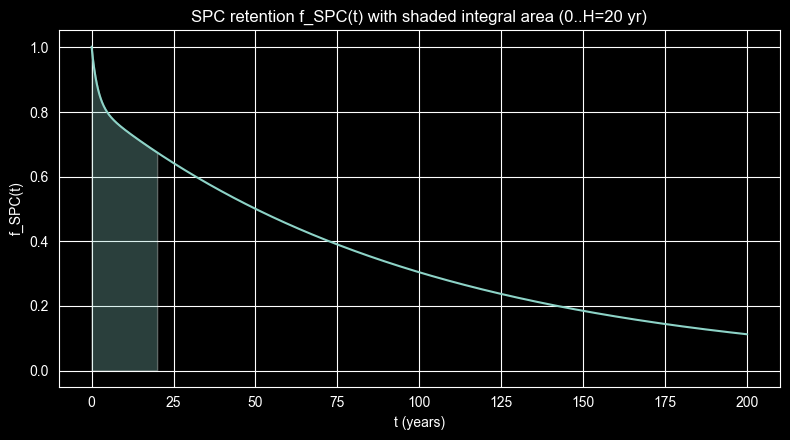

In [3]:
# --- User choices (edit here)
H = 20
n = 20_000
SPC_start = 1000

remaining = round(f_SPC(H) * SPC_start,1)
val_a = SPC_int_analytic(H)
val_n = SPC_int_numeric(H, n=n)

print(f"SPC remaining after {H} years = {remaining} tCO2e")
print(f"SPC_int_analytic(H={H}) = {val_a:.12f} yr - this is the value to use for TCE(H)")
print(f"SPC_int_numeric (H={H}) = {val_n:.12f} yr  this is a sanity check using {n} trapezoids.")
print(f"abs diff = {abs(val_n - val_a):.3e} yr")


# --- Plot choices
tmax = 200
dt = 0.1

t = np.arange(0.0, tmax + dt, dt)
yvals = f_SPC(t)

mask = (t <= H)

plt.figure(figsize=(8, 4.5))
plt.plot(t, yvals)
plt.fill_between(t[mask], 0, yvals[mask], alpha=0.3)
plt.xlabel("t (years)")
plt.ylabel("f_SPC(t)")
plt.title(f"SPC retention f_SPC(t) with shaded integral area (0..H={H} yr)")
plt.tight_layout()
plt.show()


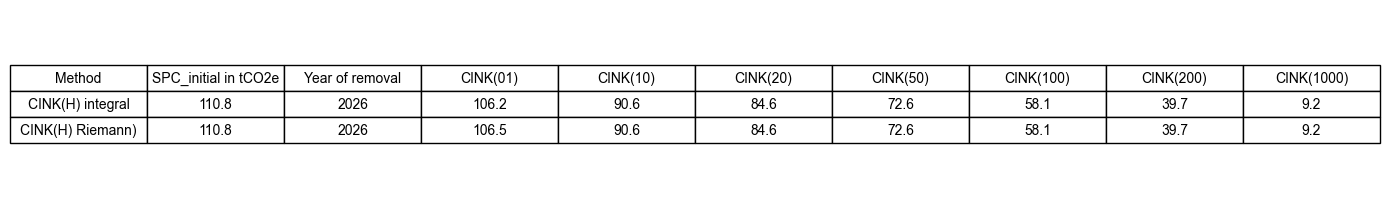

In [23]:
# CINK Calculation # CINK(H) is the average annual C-sink amount
# CINK(H) is the sum of the annual Int_SPC over each years until the end of the time horizon H divided by H to obtain the average annual sink factor.
# CINK(H) can also be calculated as Int from t=0 to H of fSPC(t)dt diveded by 0
# Standards may also accept to use the trapezoide Riemann Sum over the years until H

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inputs
SPC_initial = 110.8 #25 is like in GBCS table # 110.8 for 1 t CH4 # change here the amount of SPC you want to calculate
year_of_removal = 2026

Hs = [1, 10, 20, 50, 100, 200, 1000] # CINK(H), add H as you like
labels = [f"CINK({h:02d})" if h < 1000 else "CINK(1000)" for h in Hs]

# --- Helper: annual Int_SPC for each year i (integral from i-1 .. i)
def annual_Int_SPC(i, use_numeric=False, n=None):
    if i <= 0:
        return 0.0
    if use_numeric:
        if n is None:
            raise ValueError("n must be provided when use_numeric=True")
        return SPC_int_numeric(i, n=n) - SPC_int_numeric(i-1, n=n)
    else:
        return SPC_int_analytic(i) - SPC_int_analytic(i-1)

# --- Trapezoid approximation of integral from 0..H using yearly f_SPC samples
def CINK_trapezoid(H):
    # H must be integer here
    t = np.arange(0, H + 1, 1, dtype=float)  # 0,1,...,H
    f = np.array([f_SPC(tt) for tt in t], dtype=float)  # fSPC at integer years
    integral_approx = np.sum(0.5 * (f[:-1] + f[1:]) * 1.0)  # dt=1 year
    return integral_approx / H  # average annual factor

# --- Compute values: analytic (your annual integrals) and trapezoid (sampling f_SPC)
vals_analytic = []
vals_trap = []

for h in Hs:
    # Analytic/annual-integral version
    annual_ints = np.array([annual_Int_SPC(i) for i in range(1, h + 1)], dtype=float)
    CINK_h = annual_ints.sum() / h
    vals_analytic.append(CINK_h * SPC_initial)

    # Trapezoid version
    CINK_h_trap = CINK_trapezoid(h)
    vals_trap.append(CINK_h_trap * SPC_initial)

# --- Build 2-row DataFrame
df = pd.DataFrame([
    ["CINK(H) integral", SPC_initial, year_of_removal, *vals_analytic],
    ["CINK(H) Riemann)", SPC_initial, year_of_removal, *vals_trap]
], columns=["Method", "SPC_initial in tCO2e", "Year of removal", *labels])

# --- Prepare formatted cell text ONLY for plotting (1 decimal)
cell_text = df.copy()
for c in labels:
    cell_text[c] = cell_text[c].map(lambda x: f"{x:.1f}")

cell_text["SPC_initial in tCO2e"] = cell_text["SPC_initial in tCO2e"].map(lambda x: f"{x:.1f}")
cell_text["Year of removal"] = cell_text["Year of removal"].astype(int).astype(str)

# --- Render as Matplotlib table
fig, ax = plt.subplots(figsize=(14, 2.2))
ax.axis("off")

fig.patch.set_facecolor("white")
ax.set_facecolor("white")

tbl = ax.table(
    cellText=cell_text.values,
    colLabels=cell_text.columns,
    cellLoc="center",
    loc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)

# Force readable colors
for (row, col), cell in tbl.get_celld().items():
    cell.set_facecolor("white")
    cell.set_text_props(color="black")
    cell.set_edgecolor("black")

plt.tight_layout()
plt.savefig("../figures/CINK_table_int_vs_Riem.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()